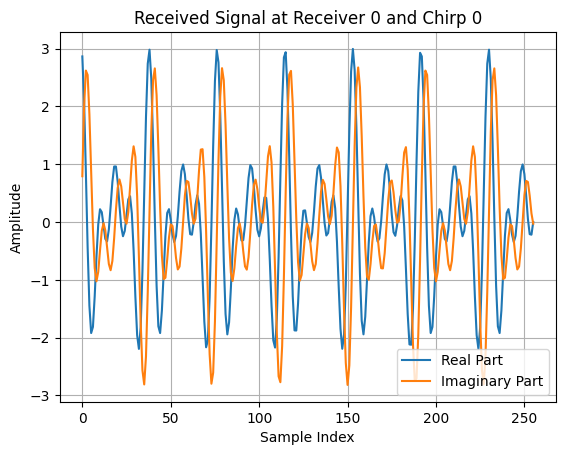

In [5]:
import numpy as np
import matplotlib.pyplot as plt

B = 200e6  # 带宽
T = 100e-6  # Chirp时长
c = 3e8  # 光速
f0 = 24e9  # 初始频率
# fs = 1.50e6  # 采样频率

N_Sample = 256  # 每个Chirp的采样点数
fs_real = 1 / (T / N_Sample)  # 实际采样率

# t = np.arange(0, T, 1/fs)  # 时间向量
k = B / T  # 频率斜率
R_FFT_N = 256  # FFT大小



N_chirp = 64  # Chirp数量
V_FFT_N = N_chirp  # 速度FFT大小
RX_N = 8  # 接收器数量
d = c / f0 / 2  # 距离分辨率
D = np.arange(RX_N) * d  # 接收器位置

tar_num = 3
R = np.array([20, 40, 30])  # 目标距离
v = np.array([15, -10, 20])  # 目标速度
theta = np.array([20, -30, 15]) * np.pi / 180  # 目标角度

rx_sig1 = np.zeros((len(R), RX_N, N_chirp, N_Sample), dtype=complex)

# for m in range(len(R)):
#     for k in range(N_chirp):
#         for L in range(RX_N):
#             for n in range(N_Sample):
#                 rx_sig1[m, L, k, n] = np.exp(1j * 2 * np.pi * (
#                     (0.5 * B / T * 2 * ((2 * (R[m] + v[m] * k * T)) / c - D[L] * np.sin(theta[m]) / c)) * T / N_Sample * n +
#                     f0 * (2 * (R[m] + v[m] * k * T) / c - D[L] * np.sin(theta[m]) / c) +
#                     0.5 * B / T * ((2 * (R[m] + v[m] * k * T)) / c - D[L] * np.sin(theta[m]) / c)**2
#                 ))

# 计算基本的常数
k_indices = np.arange(N_chirp)  # Chirp索引
n_indices = np.arange(N_Sample)  # 采样点索引
R_mat = np.tile(R, (RX_N, N_chirp, N_Sample, 1)).transpose(3, 0, 1, 2)
v_mat = np.tile(v, (RX_N, N_chirp, N_Sample, 1)).transpose(3, 0, 1, 2)
theta_mat = np.tile(theta, (RX_N, N_chirp, N_Sample, 1)).transpose(3, 0, 1, 2)
D_mat = np.tile(D, (len(R), N_chirp, N_Sample, 1)).transpose(0, 3, 1, 2)

# 计算所有的距离项
distance_terms = 2 * (R_mat + v_mat * k_indices[np.newaxis, np.newaxis, :, np.newaxis] * T) / c
angle_terms = D_mat * np.sin(theta_mat) / c

# 计算复数指数的参数
freq_sweep = 0.5 * B / T * (distance_terms - angle_terms)
initial_phase = f0 * (distance_terms - angle_terms)
quadratic_phase = 0.5 * B / T * (distance_terms - angle_terms)**2

# 计算总相位
total_phase = (freq_sweep * T / N_Sample * n_indices[np.newaxis, np.newaxis, np.newaxis, :]) + initial_phase + quadratic_phase

# 生成复数信号
rx_sig1 = np.exp(1j * 2 * np.pi * total_phase)
                
data_in = np.sum(rx_sig1, axis=0)

# 选择一个接收器和一个Chirp来可视化
L = 0
k = 0
plt.figure()
plt.plot(np.real(data_in[L, k, :]), label='Real Part')
plt.plot(np.imag(data_in[L, k, :]), label='Imaginary Part')
plt.title('Received Signal at Receiver {} and Chirp {}'.format(L, k))
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

0.7499999999999999


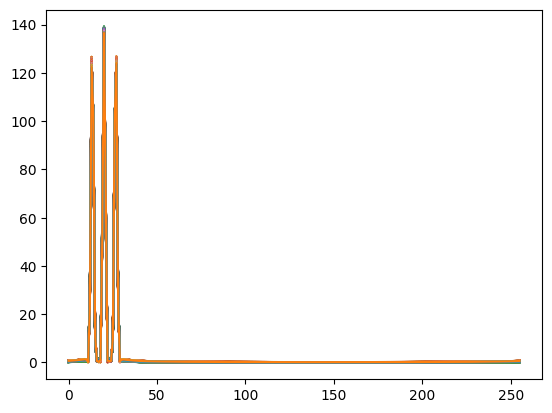

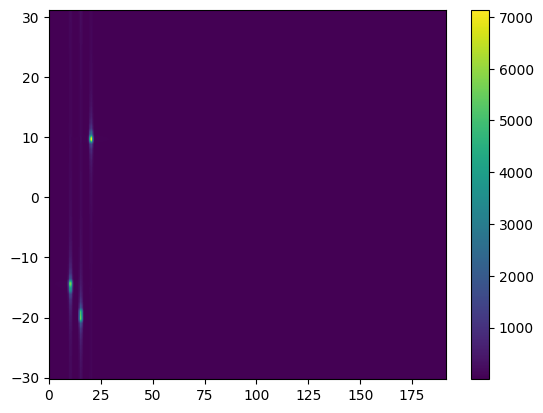

In [6]:
from scipy.signal import hamming, get_window

# 生成窗函数
window = hamming(R_FFT_N)  # 汉明窗

data_cuda = np.zeros([RX_N, N_chirp, R_FFT_N], dtype=complex)

# range FFT
# plt.figure()
for L in range(RX_N):
    for i in range(N_chirp):
        data_cuda[L, i, :] = np.fft.fft(data_in[L, i, :] * window, R_FFT_N)
        plt.plot(np.abs(data_cuda[L, i, :]))

for L in range(RX_N):
    for i in range(R_FFT_N):
         data_cuda[L, :, i] = np.fft.fftshift(np.fft.fft(data_cuda[L, :, i], N_chirp))


# 计算距离和速度坐标轴
rangeBin =  (c * T / (2*B)) * (fs_real / R_FFT_N)
print(rangeBin)
range_axis = np.linspace(0, R_FFT_N - 1, R_FFT_N) * rangeBin 

velBin = (c / f0 * 0.5) / (T * V_FFT_N)  # 速度分辨率
velocity_axis = np.linspace(-V_FFT_N / 2 + 1, V_FFT_N / 2, V_FFT_N) * velBin

plt.figure()
plt.imshow(np.abs(data_cuda[L, :, :]), aspect='auto', extent=(range_axis[0], range_axis[-1], velocity_axis[0], velocity_axis[-1]))
plt.colorbar()


In [7]:
# 距离维FFT
range_fft = np.fft.fft(data_in, n=R_FFT_N, axis=2)
# range_fft = np.fft.fftshift(range_fft, axes=2)  # FFT shift for alignment

# 速度维FFT
velocity_fft = np.fft.fft(range_fft, n=V_FFT_N, axis=1)
velocity_fft = np.fft.fftshift(velocity_fft, axes=1)  # FFT shift for alignment

# 计算距离和速度的轴
range_axis = np.linspace(0, R_FFT_N - 1, R_FFT_N) * rangeRes
velocity_axis = np.linspace(-V_FFT_N / 2, V_FFT_N / 2 - 1, V_FFT_N) * velRes

# 选择接收器
L = 0

# 可视化距离FFT结果
plt.figure()
plt.imshow(20 * np.log10(np.abs(range_fft[L, :, :])), aspect='auto', extent=(range_axis[0], range_axis[-1], 0, N_chirp))
plt.colorbar()
plt.title('Range FFT Magnitude (Receiver {})'.format(L))
plt.xlabel('Range (m)')
plt.ylabel('Chirp Index')
plt.grid(True)

# 可视化速度FFT结果
plt.figure()
plt.imshow(20 * np.log10(np.abs(velocity_fft[L, :, :])), aspect='auto', extent=(velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]))
plt.colorbar()
plt.title('Velocity FFT Magnitude (Receiver {})'.format(L))
plt.xlabel('Velocity (m/s)')
plt.ylabel('Range (m)')
plt.grid(True)

plt.show()

NameError: name 'rangeRes' is not defined